In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

from ann import *

## Problem 1

### 1.1: Derivation

Our neural network is given by: $x \rightarrow l_1 \rightarrow \sigma \rightarrow l_2 \rightarrow \sigma \rightarrow y$, for which the cost function is $L(y, y^*) := (y^* - y)^2$. Note that $l_i(x) := W_i x + b_i$.

The SGD weight update rule for some parameter $p \in \{W_i, b_i\}$ is $\Delta p := -\alpha \frac{\partial L}{\partial p}$, for some learning rate $\alpha$. Using the chain rule, we can expand this computation. To build intuition, let's start out by computing the gradient of $L$ w.r.t. $W_2$: $\frac{\partial L}{\partial W_2} = \frac{\partial L}{\partial \sigma} \frac{\partial \sigma}{\partial l_2} \frac{\partial l_2}{\partial W_2}$. Where $\mathrm{input}$ refers to the input to any particular layer:
* $\frac{\partial L}{\partial \sigma}$ is easy: $2(\mathrm{input} - y)$. Note that, here, $\mathrm{input} = y^*$ by definition.
* $\frac{\partial \sigma}{\partial l_2}$ depends on the choice of $\sigma$. We use sigmoid, i.e. $\sigma(x) = \frac{1}{1 + e^{-x}}$. Therefore, the derivative is: $\sigma(\mathrm{input}) (1 - \sigma(\mathrm{input}))$; this is a well-known fact.
* $\frac{\partial \sigma}{\partial W_2}$ is a simple matrix calculus identity: $\mathrm{input}^T$.
* Therefore, $\frac{\partial L}{\partial W_2} = 2(\mathrm{input}_\mathrm{loss} - y) * \sigma(\mathrm{input}_\mathrm{act}) (1 - \sigma(\mathrm{input}_\mathrm{act})) * \mathrm{input}_\mathrm{layer 2}^T$.

These three steps are sufficient to elucidate an algorithm that can be used to backpropagate *in general* through an arbitrary number of FC/Sigmoid layers: to get the gradient w.r.t any parameter, just iterate backwards through the network, and keep a running product of the individual gradients. More concretely:
* Store the input from the previous layer during forward propagation.
* During backpropagation: compute the gradient of the current layer's output w.r.t to its weights, then multiply that by the gradient coming from the previous backprop layer. This yields the gradient of $L$ w.r.t each parameter, which can be used to perform one SGD update.
* Return the gradient of the layer's output w.r.t its input, multiplied by the gradient coming from the previous backprop layer, so that the next backprop can use it (chain rule).

That's it!

For completeness (I think the question asks for this) here are formulas for all the weights in this two-layer net. The notation is pretty clunky.
* $\frac{\partial L}{\partial W_2} = 2(\mathrm{input}_\mathrm{loss} - y) * \sigma(\mathrm{input}_\mathrm{act2}) (1 - \sigma(\mathrm{input}_\mathrm{act2})) * \mathrm{input}_\mathrm{layer 2}^T$
* $\frac{\partial L}{\partial b_2} = 2(\mathrm{input}_\mathrm{loss} - y) * \sigma(\mathrm{input}_\mathrm{act2}) (1 - \sigma(\mathrm{input}_\mathrm{act2}))$
* $\frac{\partial L}{\partial W_1} = 2(\mathrm{input}_\mathrm{loss} - y) * \sigma(\mathrm{input}_\mathrm{act2}) (1 - \sigma(\mathrm{input}_\mathrm{act2})) * W_2 * \sigma(\mathrm{input}_\mathrm{act1}) (1 - \sigma(\mathrm{input}_\mathrm{act1})) * \mathrm{input}_\mathrm{layer 1}^T$
* $\frac{\partial L}{\partial b_1} = 2(\mathrm{input}_\mathrm{loss} - y) * \sigma(\mathrm{input}_\mathrm{act2}) (1 - \sigma(\mathrm{input}_\mathrm{act2})) * W_2 * \sigma(\mathrm{input}_\mathrm{act1}) (1 - \sigma(\mathrm{input}_\mathrm{act1}))$

### 1.2: Train Network

In [3]:
# Load + pre-process data

def get_data(fname: str, ver: str):
    assert ver in ["train", "test"]
    mat = scipy.io.loadmat(fname)
    x, y = np.asarray(mat[f"X_{ver}"]), np.asarray(mat[f"y_{ver}"]).squeeze() % 10
    y_one_hot = np.eye(10)[y]
    
    return x, y_one_hot

(train_x, train_y), (test_x, test_y) = (
    get_data("mnist_training.mat", ver="train"),
    get_data("mnist_test.mat", ver="test")
)

In [4]:
# Define NN
nn = Network(layers=[
    Dense(784, 20),
    Sigmoid(),
    Dense(20, 10),
    Sigmoid()
])

In [5]:
# Train NN
nn.fit(train_x, train_y, iters=1000000, lr=1e-2)

Epoch 0: loss = 8070.358794822186 | acc = 0.12266666666666666
Epoch 50000: loss = 1399.3256544520277 | acc = 0.6756666666666666
Epoch 100000: loss = 1070.4462229250105 | acc = 0.7566666666666667
Epoch 150000: loss = 888.1723260602392 | acc = 0.8076666666666666
Epoch 200000: loss = 613.8162673914856 | acc = 0.888
Epoch 250000: loss = 505.18775324868756 | acc = 0.909
Epoch 300000: loss = 436.008253179775 | acc = 0.9236666666666666
Epoch 350000: loss = 387.592433214367 | acc = 0.9296666666666666
Epoch 400000: loss = 351.1624267522972 | acc = 0.936
Epoch 450000: loss = 317.38174090590763 | acc = 0.9413333333333334
Epoch 500000: loss = 291.50578153174183 | acc = 0.9466666666666667
Epoch 550000: loss = 269.4500232791458 | acc = 0.9506666666666667
Epoch 600000: loss = 252.13928278698774 | acc = 0.9526666666666667
Epoch 650000: loss = 236.18498100826343 | acc = 0.9543333333333334
Epoch 700000: loss = 223.25659005613508 | acc = 0.9576666666666667
Epoch 750000: loss = 212.22233491408332 | acc = 

### 1.3: Test Network

In [6]:
def get_acc(cur_nn, x, y):
    y_pred = cur_nn.forward(x)
    acc = (y_pred.argmax(axis=1) == y.argmax(axis=1)).mean()
    return acc

In [7]:
print(f"Final test set prediction accuracy: {get_acc(nn, test_x, test_y)}")

Final test set prediction accuracy: 0.8526666666666667


### 1.4: Pick Number of Hidden Neurons
We use the suggested size of 20. As we all know, there is no specific principled method to choose hyperparameters, other than modifying them and observing the effects. Since the pset instructions note that 20 is appropriate, no additional work is required.

### 1.5: Randomly Sample Initializations
After running on 10 different random initializations, it appears that the neural network is fairly robust to changes in its initial weights, though there are some fluctuations. Overall, the performance is comparable across runs, but it might be helpful in practice to run the neural net multiple times to ensure that poor performance is not just due to bad luck.

In [8]:
def train_and_eval():
    nn = Network(layers=[
        Dense(784, 20),
        Sigmoid(),
        Dense(20, 10),
        Sigmoid()
    ])
    nn.fit(train_x, train_y, iters=500000, lr=1e-2)
    return get_acc(nn, test_x, test_y)

data = [train_and_eval() for _ in range(10)]

Epoch 0: loss = 13539.362157741234 | acc = 0.115
Epoch 25000: loss = 1980.9488555837934 | acc = 0.487
Epoch 50000: loss = 1525.753431979121 | acc = 0.6353333333333333
Epoch 75000: loss = 1289.238583262436 | acc = 0.703
Epoch 100000: loss = 1128.834283390785 | acc = 0.7476666666666667
Epoch 125000: loss = 959.4823261949748 | acc = 0.807
Epoch 150000: loss = 830.5031589911076 | acc = 0.8363333333333334
Epoch 175000: loss = 737.271839008862 | acc = 0.8593333333333333
Epoch 200000: loss = 665.940473929459 | acc = 0.8733333333333333
Epoch 225000: loss = 614.3301649229027 | acc = 0.884
Epoch 250000: loss = 569.9946149434879 | acc = 0.8913333333333333
Epoch 275000: loss = 535.7767282352676 | acc = 0.8983333333333333
Epoch 300000: loss = 505.1772157704522 | acc = 0.902
Epoch 325000: loss = 477.6263476166918 | acc = 0.9076666666666666
Epoch 350000: loss = 452.25335778174184 | acc = 0.9146666666666666
Epoch 375000: loss = 431.0498885433359 | acc = 0.9193333333333333
Epoch 400000: loss = 410.2257

Epoch 325000: loss = 686.4443560500105 | acc = 0.8303333333333334
Epoch 350000: loss = 664.9886596006386 | acc = 0.8343333333333334
Epoch 375000: loss = 649.2430208526725 | acc = 0.837
Epoch 400000: loss = 634.541841146137 | acc = 0.8393333333333334
Epoch 425000: loss = 620.8202256518686 | acc = 0.842
Epoch 450000: loss = 609.02449459993 | acc = 0.8436666666666667
Epoch 475000: loss = 597.1285407934361 | acc = 0.8456666666666667
Epoch 0: loss = 9276.51083965447 | acc = 0.091
Epoch 25000: loss = 1838.6572740106446 | acc = 0.554
Epoch 50000: loss = 1326.4750236666687 | acc = 0.7033333333333334
Epoch 75000: loss = 1073.2518554760672 | acc = 0.776
Epoch 100000: loss = 894.0358599884456 | acc = 0.823
Epoch 125000: loss = 757.0955511159378 | acc = 0.8563333333333333
Epoch 150000: loss = 663.4791214344066 | acc = 0.8753333333333333
Epoch 175000: loss = 597.3247175169524 | acc = 0.888
Epoch 200000: loss = 544.1504149938294 | acc = 0.8983333333333333
Epoch 225000: loss = 502.81476096018423 | ac

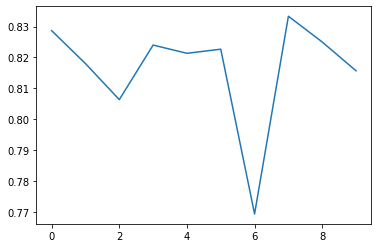

In [9]:
plt.plot(data)
plt.show()

### 1.6: Visualize Weights

Each image represents the strength of the connection from all 784 input pixels to that neuron.

One can interpret these maps as the "pattern" each particular neuron is searching for.

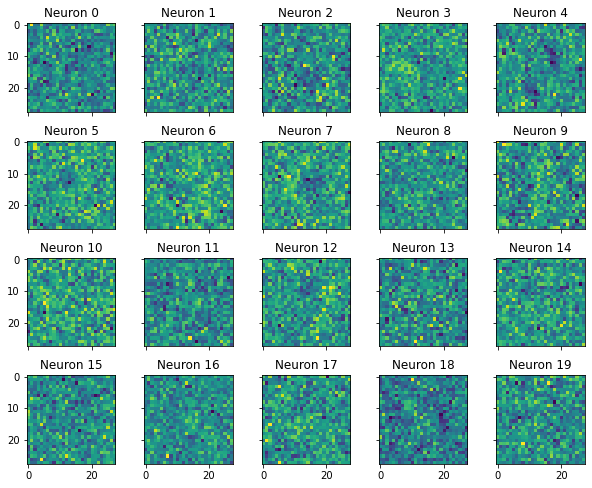

In [10]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 5),
                 axes_pad=0.4,
                 )

for i, ax in enumerate(grid):
    weight_row = nn.layers[0].w.T[i]
    ax.imshow(np.reshape(weight_row, (28, 28)))
    ax.set_title(f"Neuron {i}")

plt.show()